# Optimizacija hiperparametrov LR

In [1]:
%run __A_knjiznice.py

# Import specific elements from the script
from __A_knjiznice import *
from __B_funkcije import *
import __C_konstante as kon
%matplotlib inline

In [2]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv(f'{kon.path_files}/molekulski_prstni_odtisi/df_circular.csv')
y = df[['Activity']].values.ravel()  # Assuming 'Activity' is the target
X = df.iloc[:, 3:]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=kon.random_seed, stratify=y)

# Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=kon.random_seed)  # Increased folds for more robustness

# Define the Optuna optimization function
def objective(trial):
    # Define hyperparameters for LogisticRegression
    C = trial.suggest_float('C', 1e-5, 1e5, log=True)  # Inverse of regularization strength on a log scale
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])  # Tuning solver
    max_iter = trial.suggest_int('max_iter', 100, 2000)  # Maximum number of iterations for convergence
    
    # Define feature selection (SelectKBest)
    k_best = trial.suggest_int('k_best', 5, 300)  # Limit number of features to select
    
    # Create the pipeline without PCA
    steps = [
        ('variance_threshold', VarianceThreshold()),  # Apply VarianceThreshold to remove low-variance features
        ('select_k_best', SelectKBest(score_func=chi2, k=k_best)),  # Feature selection using SelectKBest
        ('lr', LogisticRegression(C=C, solver=solver, max_iter=max_iter, random_state=kon.random_seed))  # Logistic Regression
    ]
    
    # Create the pipeline with the selected steps
    model = Pipeline(steps)
    
    # Cross-validation: Optimize based on mean accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(cv_scores)  # Return the mean of the cross-validation scores

# Create the Optuna study and optimize it
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study.optimize(objective, n_trials=50)  # Number of trials to run (can adjust this)

# Output the best trial results
print('Best trial:')
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print(f"  Params: {best_trial.params}")

[I 2024-12-30 19:43:12,305] A new study created in memory with name: no-name-a768f53c-d789-4014-87d8-c4887babd99b
[I 2024-12-30 19:43:12,931] Trial 0 finished with value: 0.8098408315220116 and parameters: {'C': 70.22207975686683, 'solver': 'saga', 'max_iter': 1818, 'k_best': 86}. Best is trial 0 with value: 0.8098408315220116.
[I 2024-12-30 19:43:13,091] Trial 1 finished with value: 0.7932404660679052 and parameters: {'C': 62838.766768545574, 'solver': 'liblinear', 'max_iter': 1300, 'k_best': 70}. Best is trial 0 with value: 0.8098408315220116.
[I 2024-12-30 19:43:13,281] Trial 2 finished with value: 0.8273525538497994 and parameters: {'C': 84261.71647373535, 'solver': 'liblinear', 'max_iter': 489, 'k_best': 202}. Best is trial 2 with value: 0.8273525538497994.
[I 2024-12-30 19:43:13,587] Trial 3 finished with value: 0.823729454598479 and parameters: {'C': 866.6050971433493, 'solver': 'lbfgs', 'max_iter': 1373, 'k_best': 124}. Best is trial 2 with value: 0.8273525538497994.
[I 2024-12

Best trial:
  Value: 0.8542134306662474
  Params: {'C': 0.46454735620212956, 'solver': 'lbfgs', 'max_iter': 195, 'k_best': 298}


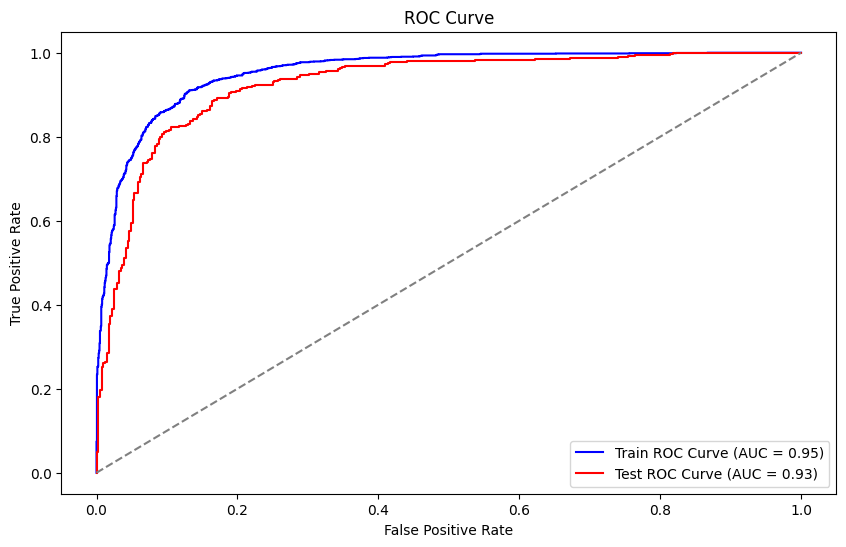

In [3]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Extract the best hyperparameters
best_params = best_trial.params
C = best_params['C']
solver = best_params['solver']
max_iter = best_params['max_iter']
k_best = best_params['k_best']

# Create the final pipeline with the best parameters
final_model = Pipeline([
    ('variance_threshold', VarianceThreshold()),  # Apply VarianceThreshold
    ('select_k_best', SelectKBest(score_func=chi2, k=k_best)),  # Feature selection using SelectKBest
    ('lr', LogisticRegression(C=C, solver=solver, max_iter=max_iter, random_state=kon.random_seed))  # Logistic Regression with the best parameters
])

# Fit the model on the full training data
final_model.fit(X_train, y_train)

# Predictions for train data
y_train_pred = final_model.predict(X_train)
y_train_prob = final_model.predict_proba(X_train)[:, 1]  # Probabilities for ROC AUC

# Predictions for test data
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate accuracy and AUC for train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC Curve (AUC = {train_auc:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC Curve (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Train Accuracy: 0.8874
Test Accuracy: 0.8504
Train AUC: 0.9541
Test AUC: 0.9251


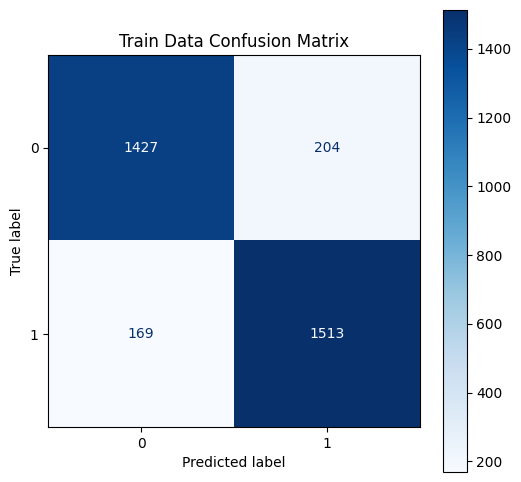

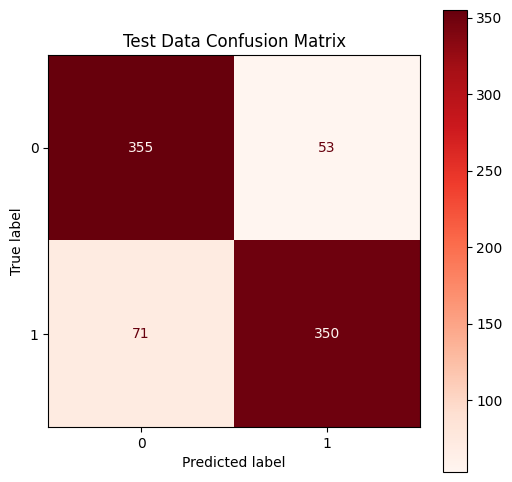

In [4]:
# Confusion Matrix for Train and Test
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

# Print accuracy and AUC scores
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


# Display Confusion Matrix for Train data
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(cmap='Blues', ax=ax)
ax.set_title('Train Data Confusion Matrix')
plt.show()

# Display Confusion Matrix for Test data
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=test_cm).plot(cmap='Reds', ax=ax)
ax.set_title('Test Data Confusion Matrix')
plt.show()